# Visual Question Answering in gluon

This is a notebook for implementing visual question answering in gluon.

In [1]:
from __future__ import print_function
import numpy as np
import mxnet as mx
import mxnet.ndarray as F
import mxnet.contrib.ndarray as C
import mxnet.gluon as gluon
from mxnet.gluon import nn
from mxnet import autograd
import bisect
from IPython.core.display import display, HTML
import logging
logging.basicConfig(level=logging.INFO)
import os
from mxnet.test_utils import download
import json
from IPython.display import HTML, display

## The VQA dataset

In the VQA dataset, for each sample, there is one image and one question. The label is the answer for the question regarding the image. You can download the VQA1.0 dataset from <a href="http://www.visualqa.org/vqa_v1_download.html">VQA</a> website. 


![](../img/pizza.png )


You need to preprocess the data:

(1) Extract the samples from original json files. 

(2) Filter the samples giving top k answers(k can be 1000, 2000...). This will make the prediction easier.

## Pretrained Models

Usually people use pretrained models to extract features from the image and question.

__Image pretrained model__: 

<a href="https://arxiv.org/abs/1409.1556">VGG</a>: A key aspect of VGG was to use many convolutional blocks with relatively narrow kernels, followed by a max-pooling step and to repeat this block multiple times. 

<a href="https://arxiv.org/abs/1512.03385">Resnet</a>: It is a residual learning framework to ease the training of networks that are substantially deep. It reformulate the layers as learning residual functions with reference to the layer inputs, instead of learning unreferenced functions.

__Question pretrained model__: 

<a href="https://code.google.com/archive/p/word2vec/">Word2Vec</a>: The word2vec tool takes a text corpus as input and produces the word vectors as output. It first constructs a vocabulary from the training text data and then learns vector representation of words. The model contains 300-dimensional vectors for 3 million words and phrases. 

<a href="https://nlp.stanford.edu/projects/glove/">Glove</a>: Similar to Word2Vec, it is a word embedding dataset. It contains 100/200/300-dimensional vectors for 2 million words.

<a href="https://arxiv.org/abs/1506.06726">skipthought</a>: This is an encoder-decoder model that tries to reconstruct the surrounding sentences of an encoded passage. Sentences that share semantic and syntactic properties are thus mapped to similar vector representations. Different from the previous two model, this is a sentence based model.

<a href="https://research.google.com/pubs/pub45610.html">GNMT encoder</a>: We propose using the encoder of google neural machine translation system to extract the question features. 

__We will discuss about how to extract the features <a href="https://github.com/shiyangdaisy23/vqa-mxnet-gluon/blob/master/extract-feature.ipynb">here</a> in details.__

## Define the model

We define out model with gluon. gluon.Block is the basic building block of models. If any operator is not defined under gluon, you can use mxnet.ndarray operators to subsititude. 

In [2]:
# Some parameters we are going to use
batch_size = 64
ctx = mx.cpu()
compute_size  = batch_size
out_dim = 10000
gpus = 1

In the __first model__, we will concatenate the image and question features and use multilayer perception(MLP) to predict the answer.

In [3]:
class Net1(gluon.Block):
    def __init__(self, **kwargs):
        super(Net1, self).__init__(**kwargs)
        with self.name_scope():
            # layers created in name_scope will inherit name space
            # from parent layer.
            self.bn = nn.BatchNorm()
            self.dropout = nn.Dropout(0.3)
            self.fc1 = nn.Dense(8192,activation="relu")
            self.fc2 = nn.Dense(1000)
            

    def forward(self, x):
        x1 = F.L2Normalization(x[0])
        x2 = F.L2Normalization(x[1])
        z = F.concat(x1,x2,dim=1)
        z = self.fc1(z)
        z = self.bn(z)
        z = self.dropout(z)
        z = self.fc2(z)
        return z


In the __second model__, instead of linearly combine the image and text features, we use count sketch to estimate the outer product of the image and question features. It is also named as multimodel compact bilinear pooling(MCB).

This method was proposed in <a href="https://arxiv.org/abs/1606.01847">Multimodal Compact Bilinear Pooling for VQA</a>. The key idea is:

$\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \psi(x \otimes y, h,s) = \psi(x,h,s) \star \psi(y,h,s)$

where $\psi$ is the count sketch operator, $x,y$ are the inputs, $h, s$ are the hash tables, $\otimes$ defines outer product and $\star$ is the convolution operator. This can further be simplified by using FFT properties: convolution in time domain equals to elementwise product in frequency domain.

One improvement we made is adding ones vectors to each features before count sketch. The intuition is: given input vectors $x,y$, estimating outer product between $[x,1s]$ and $[y, 1s]$ gives us information more than just $x \otimes y$. It also contains information of $x$ and $y$.

In [4]:
class Net2(gluon.Block):
    def __init__(self, **kwargs):
        super(Net2, self).__init__(**kwargs)
        with self.name_scope():
            # layers created in name_scope will inherit name space
            # from parent layer.
            self.bn = nn.BatchNorm()
            self.dropout = nn.Dropout(0.3)
            self.fc1 = nn.Dense(8192,activation="relu")
            self.fc2 = nn.Dense(1000)
            

    def forward(self, x):
        x1 = F.L2Normalization(x[0])
        x2 = F.L2Normalization(x[1])
        text_ones = F.ones((batch_size/gpus, 2048),ctx = ctx)
        img_ones = F.ones((batch_size/gpus, 1024),ctx = ctx)
        text_data = F.Concat(x1, text_ones,dim = 1)
        image_data = F.Concat(x2,img_ones,dim = 1)
        # Initialize hash tables
        S1 = F.array(np.random.randint(0, 2, (1,3072))*2-1,ctx = ctx)
        H1 = F.array(np.random.randint(0, out_dim,(1,3072)),ctx = ctx)
        S2 = F.array(np.random.randint(0, 2, (1,3072))*2-1,ctx = ctx)
        H2 = F.array(np.random.randint(0, out_dim,(1,3072)),ctx = ctx)
        # Count sketch
        cs1 = C.count_sketch( data = image_data, s=S1, h = H1 ,name='cs1',out_dim = out_dim) 
        cs2 = C.count_sketch( data = text_data, s=S2, h = H2 ,name='cs2',out_dim = out_dim) 
        fft1 = C.fft(data = cs1, name='fft1', compute_size = compute_size) 
        fft2 = C.fft(data = cs2, name='fft2', compute_size = compute_size) 
        c = fft1 * fft2
        ifft1 = C.ifft(data = c, name='ifft1', compute_size = compute_size) 
        # MLP
        z = self.fc1(ifft1)
        z = self.bn(z)
        z = self.dropout(z)
        z = self.fc2(z)
        return z

__We will introduce attention model in this <a href="https://github.com/shiyangdaisy23/vqa-mxnet-gluon/blob/master/Attention-VQA-gluon.ipynb">notebook</a>.__

## Data Iterator

The inputs of the data iterator are extracted image and question features. At each step, the data iterator will return a data batch list: question data batch and image data batch. 

We need to seperate the data batches by the length of the input data because the input questions are in different lengths. The $buckets$ parameter defines the max length you want to keep in the data iterator. Here since we already used pretrained model to extract the question feature, the question length is fixed as the output of the pretrained model.

The $layout$ parameter defines the layout of the data iterator output. "N" specify where is the data batch dimension is.

$reset()$ function is called after every epoch. $next()$ function is call after each batch.

In [5]:
class VQAtrainIter(mx.io.DataIter):
    def __init__(self, img, sentences, answer, batch_size, buckets=None, invalid_label=-1,
                 text_name='text', img_name = 'image', label_name='softmax_label', dtype='float32', layout='NTC'):
        super(VQAtrainIter, self).__init__()
        if not buckets:
            buckets = [i for i, j in enumerate(np.bincount([len(s) for s in sentences]))
                       if j >= batch_size]
        buckets.sort()

        ndiscard = 0
        self.data = [[] for _ in buckets]
        for i in range(len(sentences)):
            buck = bisect.bisect_left(buckets, len(sentences[i]))
            if buck == len(buckets):
                ndiscard += 1
                continue
            buff = np.full((buckets[buck],), invalid_label, dtype=dtype)
            buff[:len(sentences[i])] = sentences[i]
            self.data[buck].append(buff)

        self.data = [np.asarray(i, dtype=dtype) for i in self.data]
        self.answer = answer
        self.img = img
        print("WARNING: discarded %d sentences longer than the largest bucket."%ndiscard)

        self.batch_size = batch_size
        self.buckets = buckets
        self.text_name = text_name
        self.img_name = img_name
        self.label_name = label_name
        self.dtype = dtype
        self.invalid_label = invalid_label
        self.nd_text = []
        self.nd_img = []
        self.ndlabel = []
        self.major_axis = layout.find('N')
        self.default_bucket_key = max(buckets)

        if self.major_axis == 0:
            self.provide_data = [(text_name, (batch_size, self.default_bucket_key)),
                                 (img_name, (batch_size, self.default_bucket_key))]
            self.provide_label = [(label_name, (batch_size, self.default_bucket_key))]
        elif self.major_axis == 1:
            self.provide_data = [(text_name, (self.default_bucket_key, batch_size)),
                                 (img_name, (self.default_bucket_key, batch_size))]
            self.provide_label = [(label_name, (self.default_bucket_key, batch_size))]
        else:
            raise ValueError("Invalid layout %s: Must by NT (batch major) or TN (time major)")

        self.idx = []
        for i, buck in enumerate(self.data):
            self.idx.extend([(i, j) for j in range(0, len(buck) - batch_size + 1, batch_size)])
        self.curr_idx = 0

        self.reset()

    def reset(self):
        self.curr_idx = 0
        self.nd_text = []
        self.nd_img = []
        self.ndlabel = []
        for buck in self.data:
            label = np.empty_like(buck.shape[0])
            label = self.answer
            self.nd_text.append(mx.ndarray.array(buck, dtype=self.dtype))
            self.nd_img.append(mx.ndarray.array(self.img, dtype=self.dtype))
            self.ndlabel.append(mx.ndarray.array(label, dtype=self.dtype))

    def next(self):
        if self.curr_idx == len(self.idx):
            raise StopIteration
        i, j = self.idx[self.curr_idx]
        self.curr_idx += 1

        if self.major_axis == 1:
            img = self.nd_img[i][j:j + self.batch_size].T
            text = self.nd_text[i][j:j + self.batch_size].T
            label = self.ndlabel[i][j:j+self.batch_size]
        else:
            img = self.nd_img[i][j:j + self.batch_size]
            text = self.nd_text[i][j:j + self.batch_size]
            label = self.ndlabel[i][j:j+self.batch_size]
        
        data = [text, img]
        return mx.io.DataBatch(data, [label],
                         bucket_key=self.buckets[i],
                         provide_data=[(self.text_name, text.shape),(self.img_name, img.shape)],
                         provide_label=[(self.label_name, label.shape)])

## Load the data

Here we will use subset of VQA dataset in this tutorial. We extract the image feature from ResNet-152, text feature from GNMT encoder. In first two model, we have 21537 training samples and 1044 validation samples in this tutorial. Image feature is a 2048-dim vector. Question feature is a 1048-dim vector. 

In [6]:
# Download the dataset
dataset_files = {'train': ('train_question.npz','train_img.npz','train_ans.npz'),
                 'validation': ('val_question.npz','val_img.npz','val_ans.npz'),
                 'test':('test_question_id.npz','test_question.npz','test_img_id.npz','test_img.npz','atoi.json','test_question_txt.json')}

train_q, train_i, train_a = dataset_files['train']
val_q, val_i, val_a = dataset_files['validation']

url_format = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/VQA-notebook/{}'
if not os.path.exists(train_q):
    logging.info('Downloading training dataset.')
    download(url_format.format(train_q),overwrite=True)
    download(url_format.format(train_i),overwrite=True)
    download(url_format.format(train_a),overwrite=True)
if not os.path.exists(val_q):
    logging.info('Downloading validation dataset.')
    download(url_format.format(val_q),overwrite=True)
    download(url_format.format(val_i),overwrite=True)
    download(url_format.format(val_a),overwrite=True)


INFO:root:Downloading training dataset.
INFO:root:downloaded https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/VQA-notebook/train_question.npz into train_question.npz successfully
INFO:root:downloaded https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/VQA-notebook/train_img.npz into train_img.npz successfully
INFO:root:downloaded https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/VQA-notebook/train_ans.npz into train_ans.npz successfully
INFO:root:Downloading validation dataset.
INFO:root:downloaded https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/VQA-notebook/val_question.npz into val_question.npz successfully
INFO:root:downloaded https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/VQA-notebook/val_img.npz into val_img.npz successfully
INFO:root:downloaded https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/VQA-notebook/val_ans.npz into val_ans.npz successfully


In [7]:
layout = 'NT'
bucket = [1024]

train_question = np.load(train_q)['x']
val_question = np.load(val_q)['x']
train_ans = np.load(train_a)['x']
val_ans = np.load(val_a)['x']
train_img = np.load(train_i)['x']
val_img = np.load(val_i)['x']

print("Total training sample:",train_ans.shape[0])   
print("Total validation sample:",val_ans.shape[0])   

data_train  = VQAtrainIter(train_img, train_question, train_ans, batch_size, buckets = bucket,layout=layout)
data_eva = VQAtrainIter(val_img, val_question, val_ans, batch_size, buckets = bucket,layout=layout) 


Total training sample: 21537
Total validation sample: 1044


## Initialize the Parameters

In [8]:
net = Net1()
#net = Net2()
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

## Loss and Evaluation Metrics

In [9]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

metric = mx.metric.Accuracy()

def evaluate_accuracy(data_iterator, net):
    numerator = 0.
    denominator = 0.
    
    data_iterator.reset()
    for i, batch in enumerate(data_iterator):
        with autograd.record():
            data1 = batch.data[0].as_in_context(ctx)
            data2 = batch.data[1].as_in_context(ctx)
            data = [data1,data2]
            label = batch.label[0].as_in_context(ctx)
            output = net(data)
        
        metric.update([label], [output])
    return metric.get()[1]


## Optimizer

In [10]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})

## Training loop

In [11]:
epochs = 10
moving_loss = 0.
best_eva = 0
for e in range(epochs):
    data_train.reset()
    for i, batch in enumerate(data_train):
        data1 = batch.data[0].as_in_context(ctx)
        data2 = batch.data[1].as_in_context(ctx)
        data = [data1,data2]
        label = batch.label[0].as_in_context(ctx)
        with autograd.record():
            output = net(data)
            cross_entropy = loss(output, label)
            cross_entropy.backward()
        trainer.step(data[0].shape[0])
        
        ##########################
        #  Keep a moving average of the losses
        ##########################
        if i == 0:
            moving_loss = np.mean(cross_entropy.asnumpy()[0])
        else:
            moving_loss = .99 * moving_loss + .01 * np.mean(cross_entropy.asnumpy()[0])
        #if i % 200 == 0:
        #    print("Epoch %s, batch %s. Moving avg of loss: %s" % (e, i, moving_loss))   
    eva_accuracy = evaluate_accuracy(data_eva, net)
    train_accuracy = evaluate_accuracy(data_train, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Eval_acc %s" % (e, moving_loss, train_accuracy, eva_accuracy))
    if eva_accuracy > best_eva:
            best_eva = eva_accuracy
            logging.info('Best validation acc found. Checkpointing...')
            net.save_parameters('vqa-mlp-%d.params'%(e))


INFO:root:Best validation acc found. Checkpointing...


Epoch 0. Loss: 3.07848375872, Train_acc 0.439319957386, Eval_acc 0.3525390625


INFO:root:Best validation acc found. Checkpointing...


Epoch 1. Loss: 2.08781239439, Train_acc 0.478870738636, Eval_acc 0.436820652174


INFO:root:Best validation acc found. Checkpointing...


Epoch 2. Loss: 1.63500481371, Train_acc 0.515536221591, Eval_acc 0.476584201389


INFO:root:Best validation acc found. Checkpointing...


Epoch 3. Loss: 1.45585072303, Train_acc 0.549283114347, Eval_acc 0.513701026119


INFO:root:Best validation acc found. Checkpointing...


Epoch 4. Loss: 1.17097555747, Train_acc 0.579172585227, Eval_acc 0.547500438904


INFO:root:Best validation acc found. Checkpointing...


Epoch 5. Loss: 1.0625076159, Train_acc 0.606460108902, Eval_acc 0.577517947635


INFO:root:Best validation acc found. Checkpointing...


Epoch 6. Loss: 0.832051645247, Train_acc 0.629863788555, Eval_acc 0.60488868656


INFO:root:Best validation acc found. Checkpointing...


Epoch 7. Loss: 0.749606922723, Train_acc 0.650507146662, Eval_acc 0.62833921371


INFO:root:Best validation acc found. Checkpointing...


Epoch 8. Loss: 0.680526961879, Train_acc 0.668269610164, Eval_acc 0.649105093573


INFO:root:Best validation acc found. Checkpointing...


Epoch 9. Loss: 0.53362678042, Train_acc 0.683984375, Eval_acc 0.666923484611


## Try it out!

Currently we have test data for the first two models we mentioned above. After the training loop over Net1 or Net2, we can try it on test data. Here we have 10 test samples. 

In [12]:
test = True
if test:
    test_q_id, test_q, test_i_id, test_i, atoi,text = dataset_files['test']

if test and not os.path.exists(test_q):     
    logging.info('Downloading test dataset.')
    download(url_format.format(test_q_id),overwrite=True)
    download(url_format.format(test_q),overwrite=True)
    download(url_format.format(test_i_id),overwrite=True)
    download(url_format.format(test_i),overwrite=True)
    download(url_format.format(atoi),overwrite=True)
    download(url_format.format(text),overwrite=True)

if test:
    test_question = np.load("test_question.npz")['x']
    test_img = np.load("test_img.npz")['x']
    test_question_id = np.load("test_question_id.npz")['x']
    test_img_id = np.load("test_img_id.npz")['x']
    #atoi = np.load("atoi.json")['x']    

INFO:root:Downloading test dataset.
INFO:root:downloaded https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/VQA-notebook/test_question_id.npz into test_question_id.npz successfully
INFO:root:downloaded https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/VQA-notebook/test_question.npz into test_question.npz successfully
INFO:root:downloaded https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/VQA-notebook/test_img_id.npz into test_img_id.npz successfully
INFO:root:downloaded https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/VQA-notebook/test_img.npz into test_img.npz successfully
INFO:root:downloaded https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/VQA-notebook/atoi.json into atoi.json successfully
INFO:root:downloaded https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/VQA-notebook/test_question_txt.json into test_question_txt.json successfully


We pass the test data iterator to the trained model.

In [13]:
data_test = VQAtrainIter(test_img, test_question, np.zeros((test_img.shape[0],1)), 10, buckets = bucket,layout=layout)
for i, batch in enumerate(data_test):
    with autograd.record():
        data1 = batch.data[0].as_in_context(ctx)
        data2 = batch.data[1].as_in_context(ctx)
        data = [data1,data2]
        #label = batch.label[0].as_in_context(ctx)
        #label_one_hot = nd.one_hot(label, 10)
        output = net(data)
output = np.argmax(output.asnumpy(), axis = 1)

In [17]:
idx = np.random.randint(10)
print(idx)
question = json.load(open(text))
print("Question:", question[idx])

6
Question: Is there a boat in the water?


INFO:root:Downloading training dataset.
INFO:root:downloaded https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/VQA-notebook/test_images/COCO_test2015_000000419358.jpg into COCO_test2015_000000419358.jpg successfully


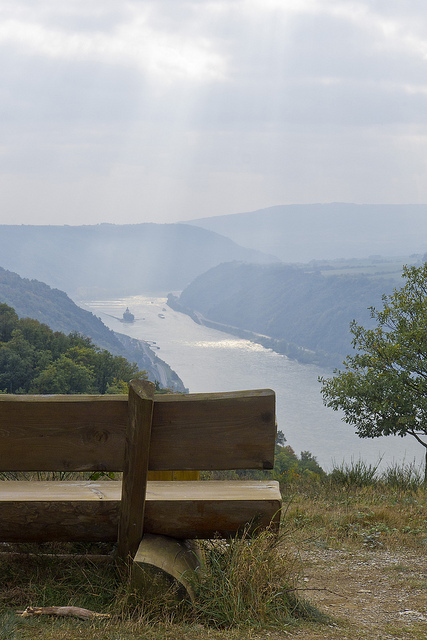

In [18]:
image_name = 'COCO_test2015_' + str(int(test_img_id[idx])).zfill(12)+'.jpg'
if not os.path.exists(image_name):
    logging.info('Downloading training dataset.')
    download(url_format.format('test_images/'+image_name),overwrite=True)

from IPython.display import Image
Image(filename=image_name) 

In [19]:
dataset = json.load(open('atoi.json'))
ans = dataset['ix_to_ans'][str(output[idx]+1)]
print("Answer:", ans)

Answer: yes


For whinges or inquiries, [open an issue on  GitHub.](https://github.com/zackchase/mxnet-the-straight-dope)